# Production Engineering

## Contents

- **Part 1 - Production Engineering functions**
    - 1.1. Productivity Index taking into acount petrophysical and fluid propierties
    - 1.2. Productivity Index with productivity test data
    - 1.3. Oil Flow Rate at Bubble Point
    - 1.4. AOF at different conditions
    - 1.5. Qo at Different Conditions
        - 1.5.1 Using Darcy's equation (linear)
        - 1.5.2 Using Vogel's method (non linear)
        - 1.5.3 Generating composite IPR Curve

- **Part 2 - IPR Curves**
    - 2.1. Non-automated IPR curve
    - 2.2. Automated IPR curve using a function
    - 2.3. IPR curve valid for the 3 methods reviewed

- **Exercises**
- **Test**

![Picture title](Resources/prod.png)

# *Reservoir Inflow Behaviour*

In this notebook, there are several functions which serve as input data to generate a function that allows to build **IPR (Inflow Performance Relationship) curves**. Two fundamental functions are presented for the calculation of the IPR based on the **Darcy and Voguel** equations, which are used to calculate the following parameters:

- $J$: Productivity Index
- $Q_{b}$: Bubble point flow rate.
- $AOF$: Maximum flow rate
- $Q_{o}$: Oil flow rate

***

![multiphase flow](Resources/inflow.png)
*Figure 1. Oil reservoir*

# Import Python Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# **Part 1. Production engineering functions**

In this section, functions are generated to calculate the parameters mentioned at the beginning:

- $J$: Productivity Index
- $Q_{b}$: Bubble point flow rate
- $AOF$: Maximum flow rate
- $Q_{o}$: Oil flow rate, using the methods of:
    - Darcy
    - Voguel
    - Composite IPR
    - Standing

## **1.1. Productivity Index Taking into account Petrophysical and Fluid Properties**

$$J=\frac{K_{o}\,h}{141.2\,B_{o}\,u_{o}(\ln{\frac{r_{e}}{r_{w}}}-0.75+s)}$$

**Where:** \
*$J$:* Productivity Index (bpd/psi)\
*$K_{o}$:* Effective permeablity (md)\
*$h$:* Thickness (ft)\
*$B_{o}$:* Oil Formation Volume Factor (rb/stb)\
*$u_{o}$:* Oil Viscosity (cp)\
*$r_{e}$:* Drainage radius (ft)\
*$r_{w}$:* Well radius (ft)\
*$s$:* Skin

In [9]:
# Productivity Index (darcy law)
def j_darcy(ko, h, bo, uo, re, rw, s, flow_regime = 'seudocontinuo'):
    if flow_regime == 'seudocontinuo':
        J_darcy = ko * h / (141.2 * bo * uo * (np.log(re / rw) - 0.75 + s))
    elif flow_regime == 'continuo':
        J_darcy = ko * h / (141.2 * bo * uo * (np.log(re / rw) + s))
    return J_darcy

## **1.2. Productivity Index with productivity test data**

In the elaboration of all these functions, it will be important to note that the arguments **$EF$ and $EF_{2}$** are default arguments, however, they could be changed if the need arises. For example, **$EF_{2}$** will only be used when after performing another production test in the well, it has increased its damage, or in the best case, it has decreased its damage, by the implementation of some stimulation process.

- If $EF$=1:
    -  Sí $Pwf_{test}$ >= $P_{b}$:
    
$$J=\frac{Qo_{test}}{P_{r} - Pwf_{test}}$$ 

    - Otherwise:

$$J = \frac{Qo_{test}}{(P_{r}-P_{b})+(\frac{P_{b}}{1.8})[1-0.2(\frac{Pwf_{test}}{P_{b}})-0.8(\frac{Pwf_{test}}{P_{b}})^2]}$$

The following conditions are shown, taking into account $EF\neq1$, which are used to calculate the productivity index considering the damage factor, and consequently, the flow efficiency is already 100%.

- If $EF\neq1$ y $EF_{2}$ does not exist:
    -  If $Pwf_{test}$ >= $P_{b}$:
    
$$J=\frac{Qo_{test}}{P_{r} - Pwf_{test}}$$

    - Otherwise:

$$J = \frac{Qo_{test}}{(P_{r}-P_{b})+(\frac{P_{b}}{1.8})[1.8 (1-\frac{Pwf_{test}}{P_{b}})-0.8 EF (1-\frac{Pwf_{test}}{P_{b}})^2]}$$

- If $EF\neq1$ and $EF_{2}$ exist:
    -  If $Pwf_{test}$ >= $P_{b}$:
    
$$J=\frac{Qo_{test}}{(P_{r} - Pwf_{test})EF}EF_{2}$$

    - Otherwise:
    
$$
J=\left(\frac{Q o_{\text {test }}}{\left\{\left(P_{r}-P_{b}\right)+\left(\frac{P_{b}}{1.8}\right)\left[1.8\left(1-\frac{P w f_{\text {test }}}{P_{b}}\right)-0.8 E F\left(1-\frac{P w f_{\text {test }}}{P_{b}}\right)^{2}\right]\right\} E F}\right) E F_{2}
$$

**Where:** 

*$J$:* Productivity index (bpd/psi).\
*$Qo_{test}$:* Test oil flow rate (bpd).\
*$P_{r}$:* Reservoir pressure (psia).\
*$P_{b}$:* Bubble point pressure (psia).\
*$Pwf_{test}$:* Flowing bottom pressure of test (psia).\
*$EF$:* Flow efficiency.\
*$EF_{2}$:* Well flow efficiency measured after a period of time.

In [10]:
# Productivity Index
def j(q_test, pwf_test, pr, pb, ef=1, ef2=None):
    if ef == 1:
        if pwf_test >= pb:
            J = q_test / (pr - pwf_test)
        else:
            J = q_test / ((pr - pb) + (pb / 1.8) * \
                          (1 - 0.2 * (pwf_test / pb) - 0.8 * (pwf_test / pb)**2))
    elif ef != 1 and ef2 is None:
        if pwf_test >= pb:
            J = q_test / (pr - pwf_test)
        else:
            J = q_test / ((pr - pb) + (pb / 1.8) * \
                          (1.8 * (1 - pwf_test / pb) - 0.8 * ef * (1 - pwf_test / pb)**2))
    elif ef !=1 and ef2 is not None:
        if pwf_test >= pb:
            J = ((q_test / (pr - pwf_test)) / ef) * ef2
        else:
            J = ((q_test / ((pr - pb) + (pb / 1.8) *\
                            (1.8 * (1 - pwf_test / pb) - 0.8 *\
                             ef * (1 - pwf_test / pb)**2))) / ef) * ef2
    return J

## **1.3. Oil Flow Rate at Bubble Point**

$$Q_{b}=J(P_{r} - P_{b})$$

**Where:** \
*$Q_{b}$:* Oil Flow Rate at Bubble Point (bpd) \
*$J$:* Productivity Index (bpd/psi) \
*$P_{r}$:* Reservoir Pressure (psia) \
*$P_{b}$:* Bubble Point Pressue (psia)

In [11]:
# Q(bpd) @ Pb 
def Qb(q_test, pwf_test, pr, pb, ef=1, ef2=None):
    qb = j(q_test, pwf_test, pr, pb, ef, ef2) * (pr - pb)
    return qb

## **1.4. AOF at different conditions**

It is important to note that only the equations of the first condition are shown, the rest of the equations can be derived from the codes.

- iF $EF$ = 1 y $EF_{2}$ does not exist:
    - Sí $P_{r}$ > $P_{b}$ -> The reservoir is **UNDERSATURATED**: 

In this case, there are 2 conditions: 

- If $Pwf_{tetst}$ >= $P_{b}$: 
$$AOF=JP_{r}$$ 

- Otherwise, 
$$AOF=Q_{b} + \frac{JP_{b}}{1.8}$$

- On the other hand, if $P_{r}$ <= $P_{b}$ -> the reservoir is **SATURATED:** 

At this condition:

$$AOF=\frac{Qo_{test}}{1 - 0.2 (\frac{Pwf_{test}}{P_{r}}) - 0.8 (\frac{Pwf_{test}}{P_{r}})^2}$$

**Where:**

*$AOF$:* Maximum flow rate (bpd).

*$Q_{b}$:* Bubble point flow rate(bpd).

*$J$:* Productivity index (bpd/psi).

*$P_{r}$:* Reservoir pressure (psia).

*$P_{b}$:* Bubble point pressure (psia).

*$Pwf$:* Flowing bottom pressure (psia).

*$Pwf_{test}$:* Flowing bottom pressure of test (psia).

*$Qo_{test}$:* Test oil flow rate (bpd).

*$EF$:* Flow efficiency.

*$EF_{2}$:* Well flow efficiency measured after a period of time.

In [12]:
# AOF(bpd)
def aof(q_test, pwf_test, pr, pb, ef=1, ef2=None):
    if (ef == 1 and ef2 is None):
        if pr > pb: # Yac. subsaturado
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb) * pr
            elif pwf_test <  pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef=1) + ((j(q_test, pwf_test, pr, pb) * pb) / 1.8)
        else: # Yac. Saturado
            AOF = q_test / (1 - 0.2 * (pwf_test / pr) - 0.8 * (pwf_test / pr)**2)
            
    elif (ef < 1 and ef2 is None):
        if pr > pb:
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb, ef) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef) + ((j(q_test, pwf_test, pr, pb, ef) * pb) / 1.8) * (1.8 - 0.8 * ef)
        else:
            AOF = (q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2)) * (1.8 * ef - 0.8 * ef**2)
            
    elif (ef > 1 and ef2 is None):
        if pr > pb:
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb, ef) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef) +  ((j(q_test, pwf_test, pr, pb, ef) * pb) / 1.8) * (0.624 + 0.376 * ef)
        else:
            AOF = (q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2)) * (0.624 + 0.376 * ef)
            
    elif (ef < 1 and ef2 >= 1):
        if pr > pb:
            if pwf_test >= pb:
                AOF =  j(q_test, pwf_test, pr, pb, ef, ef2) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef, ef2) + (j(q_test, pwf_test, pr, pb, ef, ef2) * pb / 1.8) * (0.624 + 0.376 * ef2)
        else:
            AOF = (q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2)) * (0.624 + 0.376 * ef2)
            
    elif (ef > 1 and ef2 <= 1):
        if pr > pb:
            if pwf_test >= pb:
                AOF = j(q_test, pwf_test, pr, pb, ef, ef2) * pr
            elif pwf_test < pb:
                AOF = Qb(q_test, pwf_test, pr, pb, ef, ef2) + (j(q_test, pwf_test, pr, pb, ef, ef2) * pb / 1.8) * (1.8 - 0.8 * ef2)
        else:
            AOF = (q_test / (1.8 * ef * (1 - pwf_test/pr) - 0.8 * ef**2 * (1 - pwf_test/pr)**2)) * (1.8 * ef - 0.8 * ef2**2)
    return AOF

## **1.5. $Q_{o}$ at Different Conditions**

### **1.5.1. $Q_{o}$ using Darcy's equation (linear method)**

This equation is valid when the reservoir is undersaturated. That is: $P_{r}$ > $P_{b}$.

$$Q_{o}=J(P_{r} - P_{wf})$$

**Where:**

*$Q_{o}$:* Oil flow rate (bpd)\
*$J$:* Productivity index (bpd/psi)\
*$P_{r}$:* Reservoir pressure (psia) \
*$P_{b}$:* Bubble point pressure (psia)

In [13]:
# Qo (bpd) @ Darcy Conditions
def qo_darcy(q_test, pwf_test, pr, pwf, pb, ef=1, ef2=None):
    qo = j(q_test, pwf_test, pr, pb) * (pr - pwf)
    return qo

### **1.5.2. $Q_{o}$ using Vogel's method**. 

This **Vogel** method, is valid for **saturated reservoir and for $EF$ = 1**.

The conditions under which the **Vogel** equation can be used are listed below:

- If $P_{r}$ <= $P_{b}$ -> the reservoir is **SATURATED**. Therefore, the **VOGEL** equation is used:

$$Q_{o}=AOF [1-0.2 (\frac{Pwf}{P_{r}})-0.8 (\frac{Pwf}{P_{r}})^2]$$


**Where:**

*$Q_{o}$:* Oil flow rate (bpd)\
*$AOF$:* Maximum flow rate (bpd)\
*$P_{r}$:* Reservoir pressure (psia)\
*$P_{b}$:* Pressure at bubble point (psia)\
*$Pwf$:* Flowing bottom pressure (psia)\
*$EF$:* Flowing efficiency

In [14]:
#Qo(bpd) @ vogel conditions
def qo_vogel(q_test, pwf_test, pr, pwf, pb, ef=1, ef2=None):
    qo = aof(q_test, pwf_test, pr, pb) * \
         (1 - 0.2 * (pwf / pr) - 0.8 * ( pwf / pr)**2)
    return qo

### **1.5.3. $Q_{o}$ to generate composite IPR curve**. 

This method combines the **Darcy equation and the Vogel equation**, because the IPR curve is **linear** up to the bubble point, and subsequently has a parabolic form, by using the **Vogel equation** for values below the bubble point.

The conditions for the calculation of this $Q_{O}$ are detailed below:

- **If $P_{r}$ > $P_{b}$** -> the reservoir is **SUBSATURED**: 

For this case, there are 2 conditions: 

- If $Pwf$ >= $P_{b}$$, the **Darcy** equation is used: 

$$Q_{o}=J(P_{r} - Pwf)$$. 

- If $Pwf$ < $P_{b}$, the **VOGEL** equation is used:

$$Q_{o}=Q_{b} + \frac{JP_{b}}{1.8}[1-0.2 (\frac{Pwf}{P_{b}})-0.8 (\frac{Pwf}{P_{b}})^2]$$

On the other hand, if $P_{r}$ <= $P_{b}$ -> THE reservoir is **SATURED:** 

To this condition, the **VOGEL** equation is also used:

$$Q_{o}=AOF[1-0.2 (\frac{Pwf}{P_{r}})-0.8 (\frac{Pwf}{P_{r}})^2]$$

**Where:**

*$Q_{o}$:* Oil flow rate (bpd)\
*$AOF$:* Maximun oil flow rate (bpd)\
*$J$:* Productivity index (bpd/psi)\
*$P_{r}$:* Reservoir pressure (psia)\
*$P_{b}$:* Pressure at bubble point\
*$Pwf$:* Flowing bottom pressure (psia)

In [15]:
#Qo(bpd) @ vogel conditions
def qo_ipr_compuesto(q_test, pwf_test, pr, pwf, pb):
    if pr > pb: # Yac. subsaturado
        if pwf >= pb:
            qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
        elif pwf < pb: 
            qo =  Qb(q_test, pwf_test, pr, pb) + \
            ((j(q_test, pwf_test, pr, pb) * pb) / 1.8) *\
            (1 - 0.2 * (pwf / pb) - 0.8 * (pwf / pb)**2)
            
    elif pr <= pb: # Yac. Saturado
        qo = aof(q_test, pwf_test, pr, pb) * \
        (1 - 0.2 * (pwf / pr) - 0.8 * ( pwf / pr)**2)
    return qo

## Taller

Program a function to calculate Qo at Standing conditions

In [16]:
# Qo(bpd) @Standing Conditions
def qo_standing(q_test, pwf_test, pr, pwf, pb, ef=1, ef2=None):
    qo = aof(q_test, pwf_test, pr, pb, ef=1) * (1.8 * ef * (1 - pwf / pr) - 0.8 * ef**2 * (1 - pwf / pr)**2)
    return qo

In [17]:
#Qo(bpd) @ all conditions
def qo(q_test, pwf_test, pr, pwf, pb, ef=1, ef2=None):
    if ef == 1 and ef2 is None:
        if pr > pb: # Yac. subsaturado
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb)
            elif pwf < pb:
                qo =  Qb(q_test, pwf_test, pr, pb) + \
                ((j(q_test, pwf_test, pr, pb) * pb) / 1.8) *\
                (1 - 0.2 * (pwf / pb) - 0.8 * (pwf / pb)**2)
        else: # Yac. Saturado
            qo = qo_vogel(q_test, pwf_test, pr, pwf, pb)

    elif ef != 1 and ef2 is None:
        if pr > pb: # Yac. subsaturado
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb, ef, ef2)
            elif pwf < pb:
                qo = Qb(q_test, pwf_test, pr, pb, ef) + \
                ((j(q_test, pwf_test, pr, pb, ef) * pb) / 1.8) *\
                (1.8 * (1 - pwf / pb) - 0.8 * ef * (1 - pwf / pb)**2)
        else: # Yac.saturado
            qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef)

    elif ef !=1 and ef2 is not None:
        if pr > pb: # Yac. subsaturado
            if pwf >= pb:
                qo = qo_darcy(q_test, pwf_test, pr, pwf, pb, ef, ef2)
            elif pwf < pb:
                qo = Qb(q_test, pwf_test, pr, pb, ef, ef2) + \
                ((j(q_test, pwf_test, pr, pb, ef, ef2) * pb) / 1.8) *\
                (1.8 * (1 - pwf / pb) - 0.8 * ef * (1 - pwf / pb)**2)
            else: #Yac. saturado
                qo = qo_standing(q_test, pwf_test, pr, pwf, pb, ef, ef2)
    return qo

# **Part 2. IPR Curves**

In [18]:
# Data from a saturated reservoir
pr = 2400 #psia
pb = 2500 #psia
pwf = 1000 #psia
q_test = 100 #stb/d
pwf_test = 1800 #psia

In [19]:
# Create Dataframe
df = pd.DataFrame()
df['Pwf(psia)'] = np.array([2400, 2000, 1500, 1000, 500, 0])
df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_vogel(q_test, pwf_test, pr, x, pb))

In [20]:
df

,Pwf(psia),Qo(bpd)
0,2400,0.000000
1,2000,69.444444
2,1500,140.625000
3,1000,194.444444
4,500,230.902778
5,0,250.000000


C:\Users\fredd\AppData\Local\Temp\ipykernel_14976\639901160.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


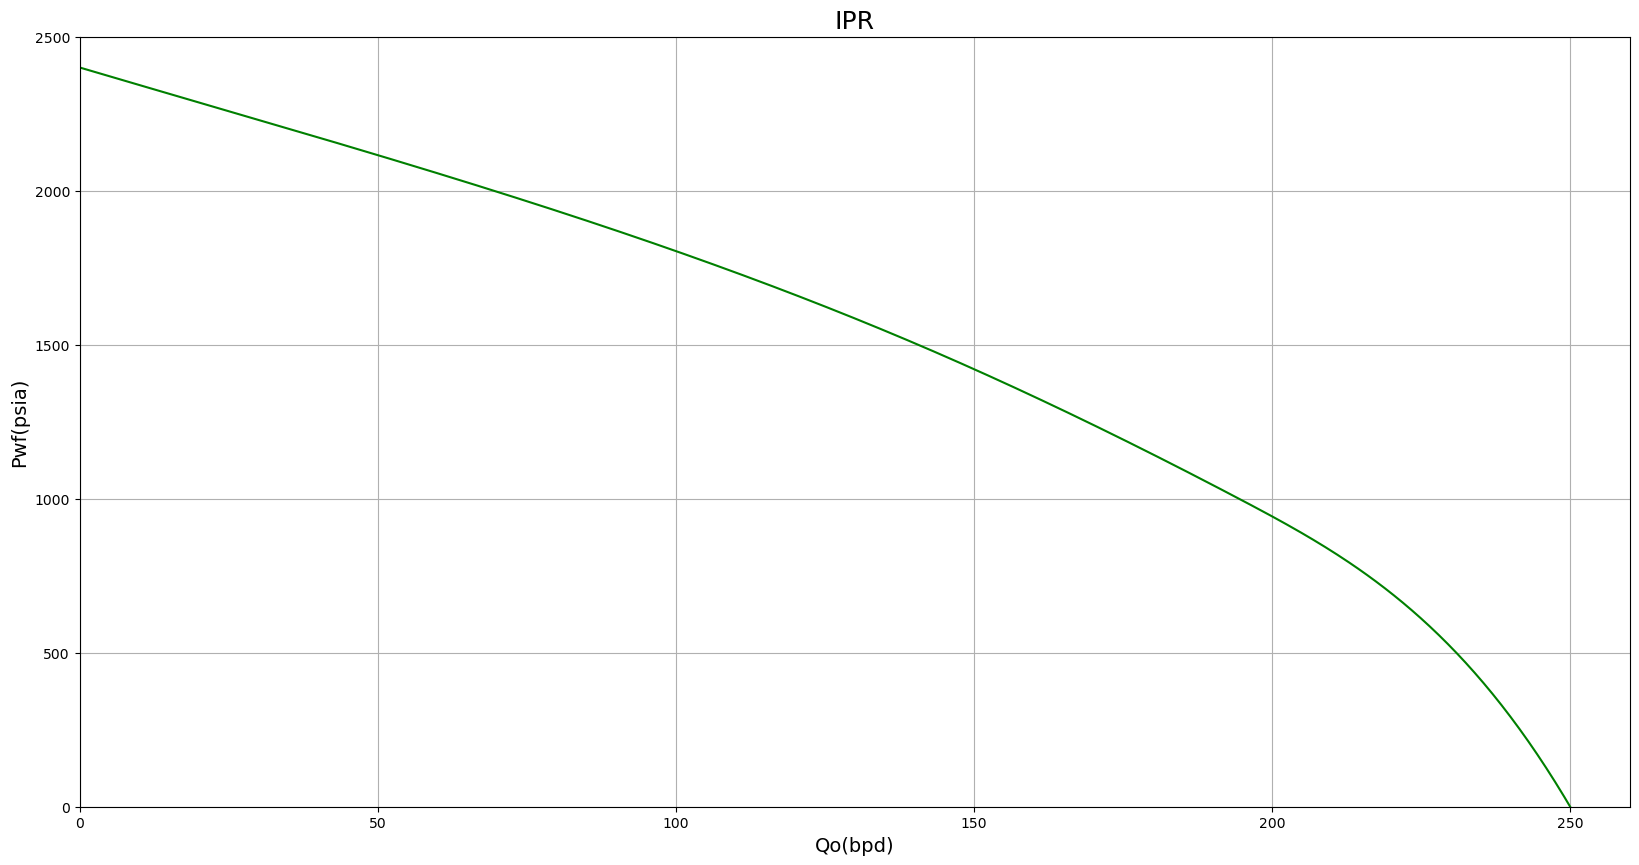

In [21]:
# Plot

fig, ax = plt.subplots(figsize=(20, 10))
x = df['Qo(bpd)']
y = df['Pwf(psia)']
X_Y_Spline = make_interp_spline(x, y) # This step is used to smooth the curve
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)
ax.plot(X_, Y_, c='g')
ax.set_xlabel('Qo(bpd)', fontsize=14)
ax.set_ylabel('Pwf(psia)', fontsize=14)
ax.set_title('IPR', fontsize=18)
ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'][0] + 100))
ax.grid()
fig.show()

Now, to automate the process, a function is created that directly generates the IPR curve.

## **2.2. Automated IPR curve using a function**

In [22]:
# IPR Curve
def IPR_curve(q_test, pwf_test, pr, pwf:list, pb):
    # Creating Dataframe
    df = pd.DataFrame()
    df['Pwf(psia)'] = pwf
    df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_ipr_compuesto(q_test, pwf_test, pr, x, pb))
    fig, ax = plt.subplots(figsize=(20, 10))
    x = df['Qo(bpd)']
    y = df['Pwf(psia)']
    # The following steps are used to smooth the curve
    X_Y_Spline = make_interp_spline(x, y) 
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    #Build the curve
    ax.plot(X_, Y_, c='g')
    ax.set_xlabel('Qo(bpd)', fontsize=14)
    ax.set_ylabel('Pwf(psia)', fontsize=14)
    ax.set_title('IPR', fontsize=18)
    ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'][0] + 100))
    # Arrow and Annotations
    plt.annotate(
    'Bubble Point', xy=(Qb(q_test, pwf_test, pr, pb), pb),xytext=(Qb(q_test, pwf_test, pr, pb) + 100, pb + 100) ,
    arrowprops=dict(arrowstyle='->',lw=1)
    )
    # Horizontal and Vertical lines at bubble point
    plt.axhline(y=pb, color='r', linestyle='--')
    plt.axvline(x=Qb(q_test, pwf_test, pr, pb), color='r', linestyle='--')
    ax.grid()
    plt.show()

In [23]:
# Data
pr = 4000 #psi
pb = 3000 #psi
q_test = 600 #bpd
pwf_test = 2000 #bpd
pwf = np.array([4000, 3500, 3000, 2500, 1000, 0])

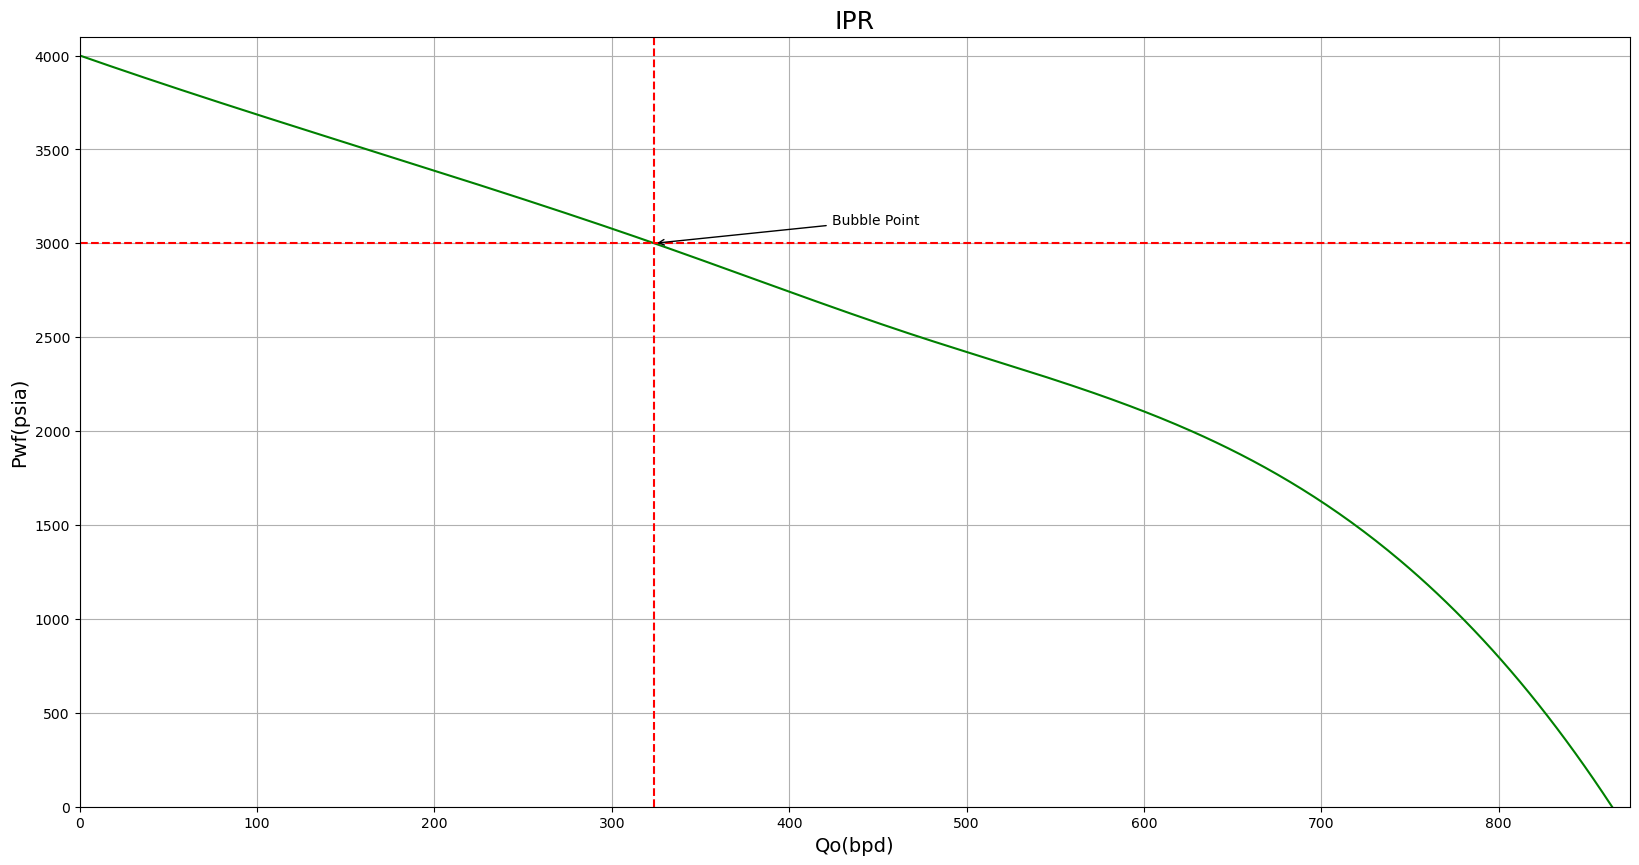

In [24]:
IPR_curve(q_test, pwf_test, pr, pwf, pb)

## **2.3. IPR curve valid for the 3 methods reviewed** 

In [25]:
# IPR Curve
def IPR_curve_methods(q_test, pwf_test, pr, pwf:list, pb, method, ef=1, ef2=None):
    # Creating Dataframe
    fig, ax = plt.subplots(figsize=(20, 10))
    df = pd.DataFrame()
    df['Pwf(psia)'] = pwf
    if method == 'Darcy':
        df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_darcy(q_test, pwf_test, pr, x, pb))
    elif method == 'Vogel':
        df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_vogel(q_test, pwf_test, pr, x, pb))
    elif method == 'IPR_compuesto':
        df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_ipr_compuesto(q_test, pwf_test, pr, x, pb))
    elif method == 'Standing':
        df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo_standing(q_test, pwf_test, pr, pwf, pb, ef=1, ef2=None))
    # Stand the axis of the IPR plot
    x = df['Qo(bpd)']
    y = df['Pwf(psia)']
    # The following steps are used to smooth the curve
    X_Y_Spline = make_interp_spline(x, y) 
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    #Build the curve
    ax.plot(X_, Y_, c='g')
    ax.set_xlabel('Qo(bpd)', fontsize=14)
    ax.set_ylabel('Pwf(psia)', fontsize=14)
    ax.set_title('IPR', fontsize=18)
    ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'].max() + 100))
    # Arrow and Annotations
    plt.annotate(
    'Bubble Point', xy=(Qb(q_test, pwf_test, pr, pb), pb),xytext=(Qb(q_test, pwf_test, pr, pb) + 100, pb + 100) ,
    arrowprops=dict(arrowstyle='->',lw=1)
    )
    # Horizontal and Vertical lines at bubble point
    plt.axhline(y=pb, color='r', linestyle='--')
    plt.axvline(x=Qb(q_test, pwf_test, pr, pb), color='r', linestyle='--')
    ax.grid()
    plt.show()

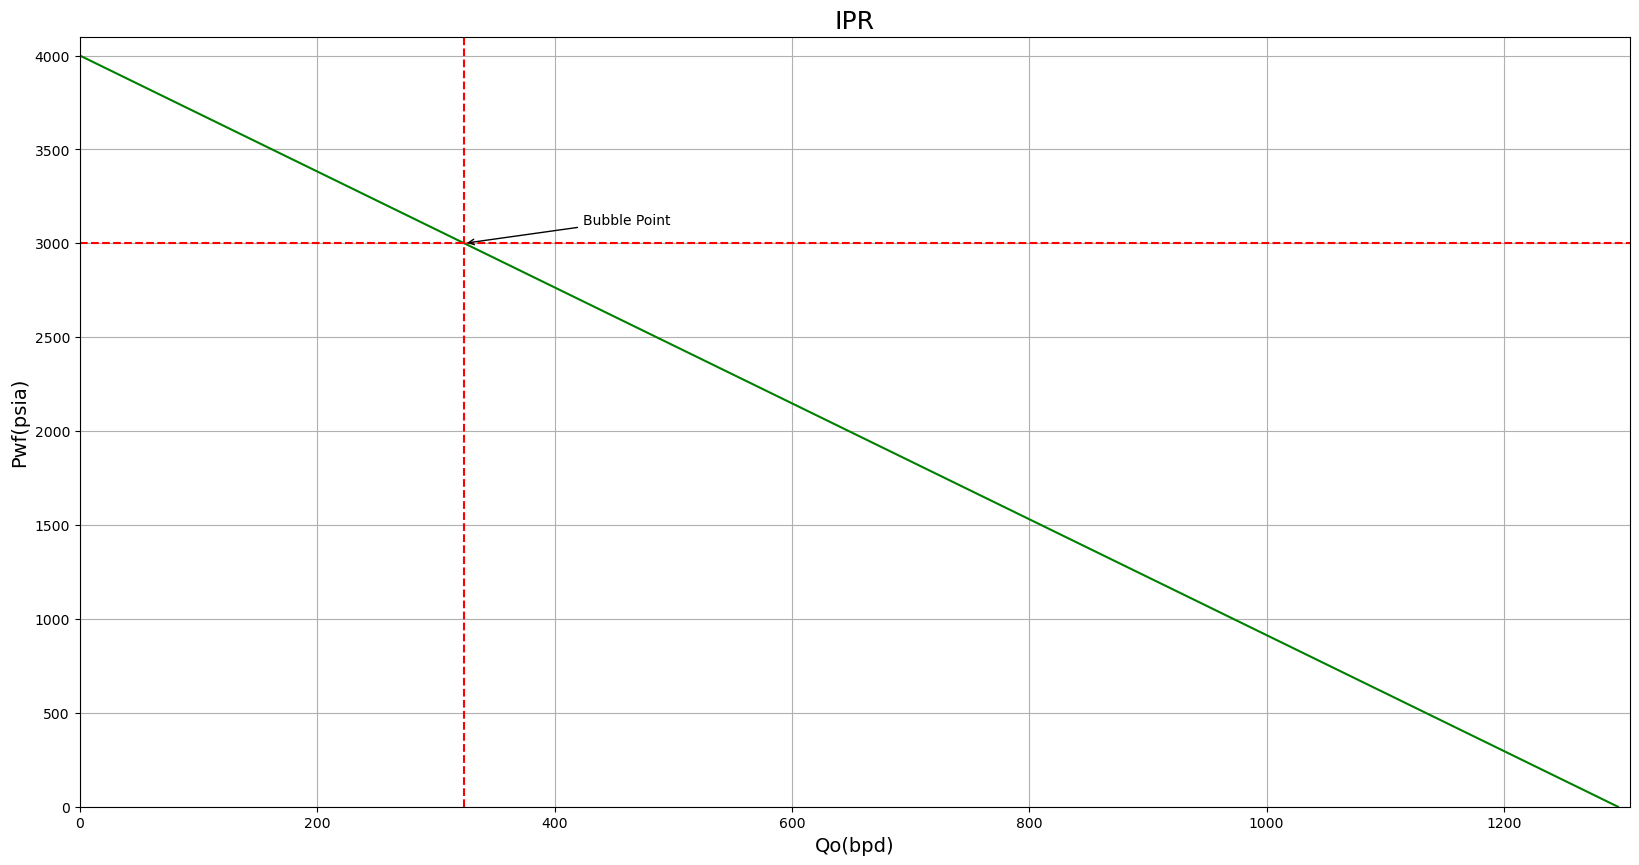

In [26]:
IPR_curve_methods(q_test, pwf_test, pr, pwf, pb, 'Darcy')

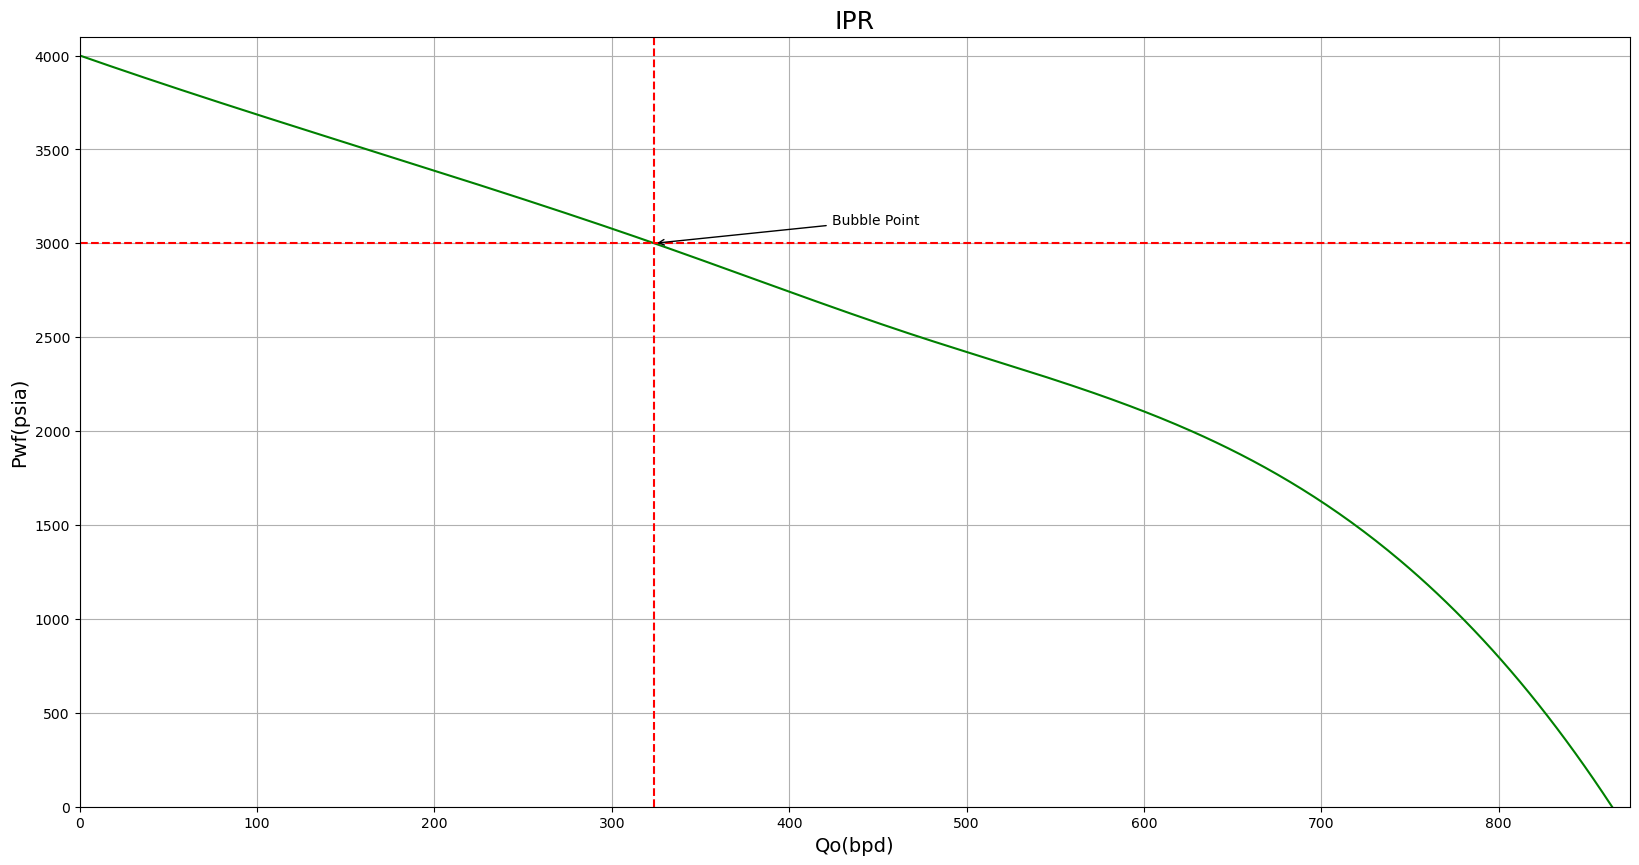

In [27]:
IPR_curve_methods(q_test, pwf_test, pr, pwf, pb, 'IPR_compuesto')

In [28]:
# Data from a saturated reservoir
pr = 2400 #psia
pb = 2500 #psia
pwf = np.array([2400, 2000, 1500, 1000, 0]) #psia
q_test = 100 #stb/d
pwf_test = 1800 #psia

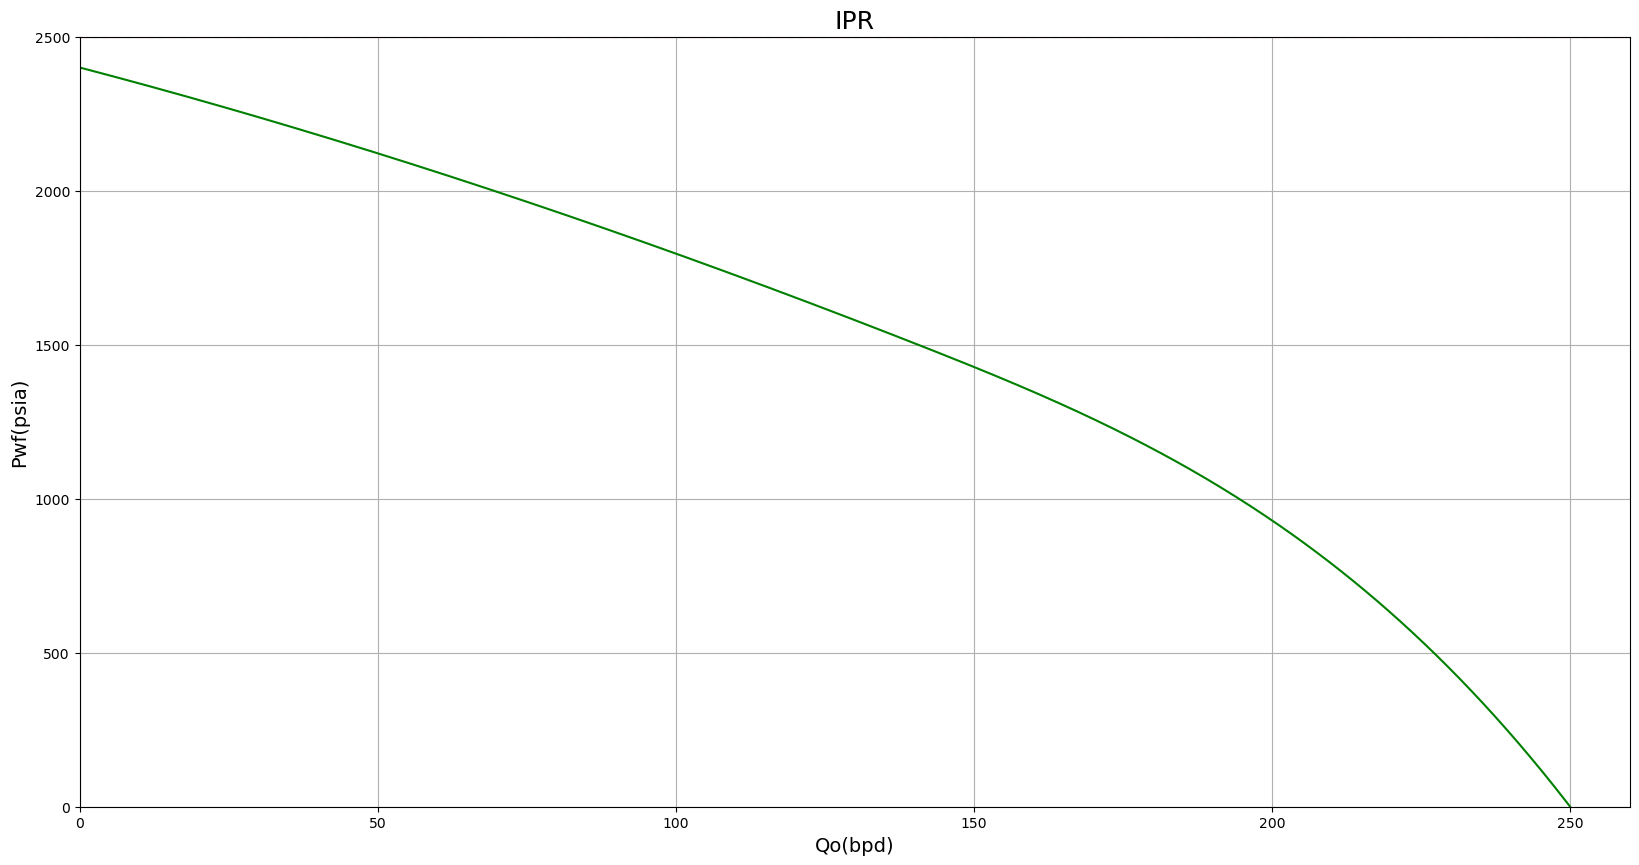

In [29]:
IPR_curve_methods(q_test, pwf_test, pr, pwf, pb, 'Vogel')

In [30]:
# IPR Curve
def IPR_Curve(q_test, pwf_test, pr, pwf:list, pb, ef=1, ef2=None, ax=None):
    # Creating Dataframe
    df = pd.DataFrame()
    df['Pwf(psia)'] = pwf
    df['Qo(bpd)'] = df['Pwf(psia)'].apply(lambda x: qo(q_test, pwf_test, pr, x, pb, ef, ef2))
    fig, ax = plt.subplots(figsize=(20, 10))
    x = df['Qo(bpd)']
    y = df['Pwf(psia)']
    # The following steps are used to smooth the curve
    X_Y_Spline = make_interp_spline(x, y) 
    X_ = np.linspace(x.min(), x.max(), 500)
    Y_ = X_Y_Spline(X_)
    #Build the curve
    ax.plot(X_, Y_, c='g')
    ax.set_xlabel('Qo(bpd)', fontsize=14)
    ax.set_ylabel('Pwf(psia)', fontsize=14)
    ax.set_title('IPR', fontsize=18)
    ax.set(xlim=(0, df['Qo(bpd)'].max() + 10), ylim=(0, df['Pwf(psia)'][0] + 100))
    # Arrow and Annotations
    plt.annotate(
    'Bubble Point', xy=(Qb(q_test, pwf_test, pr, pb), pb),xytext=(Qb(q_test, pwf_test, pr, pb) + 100, pb + 100) ,
    arrowprops=dict(arrowstyle='->',lw=1)
    )
    # Horizontal and Vertical lines at bubble point
    plt.axhline(y=pb, color='r', linestyle='--')
    plt.axvline(x=Qb(q_test, pwf_test, pr, pb), color='r', linestyle='--')
    ax.grid()
    plt.show()

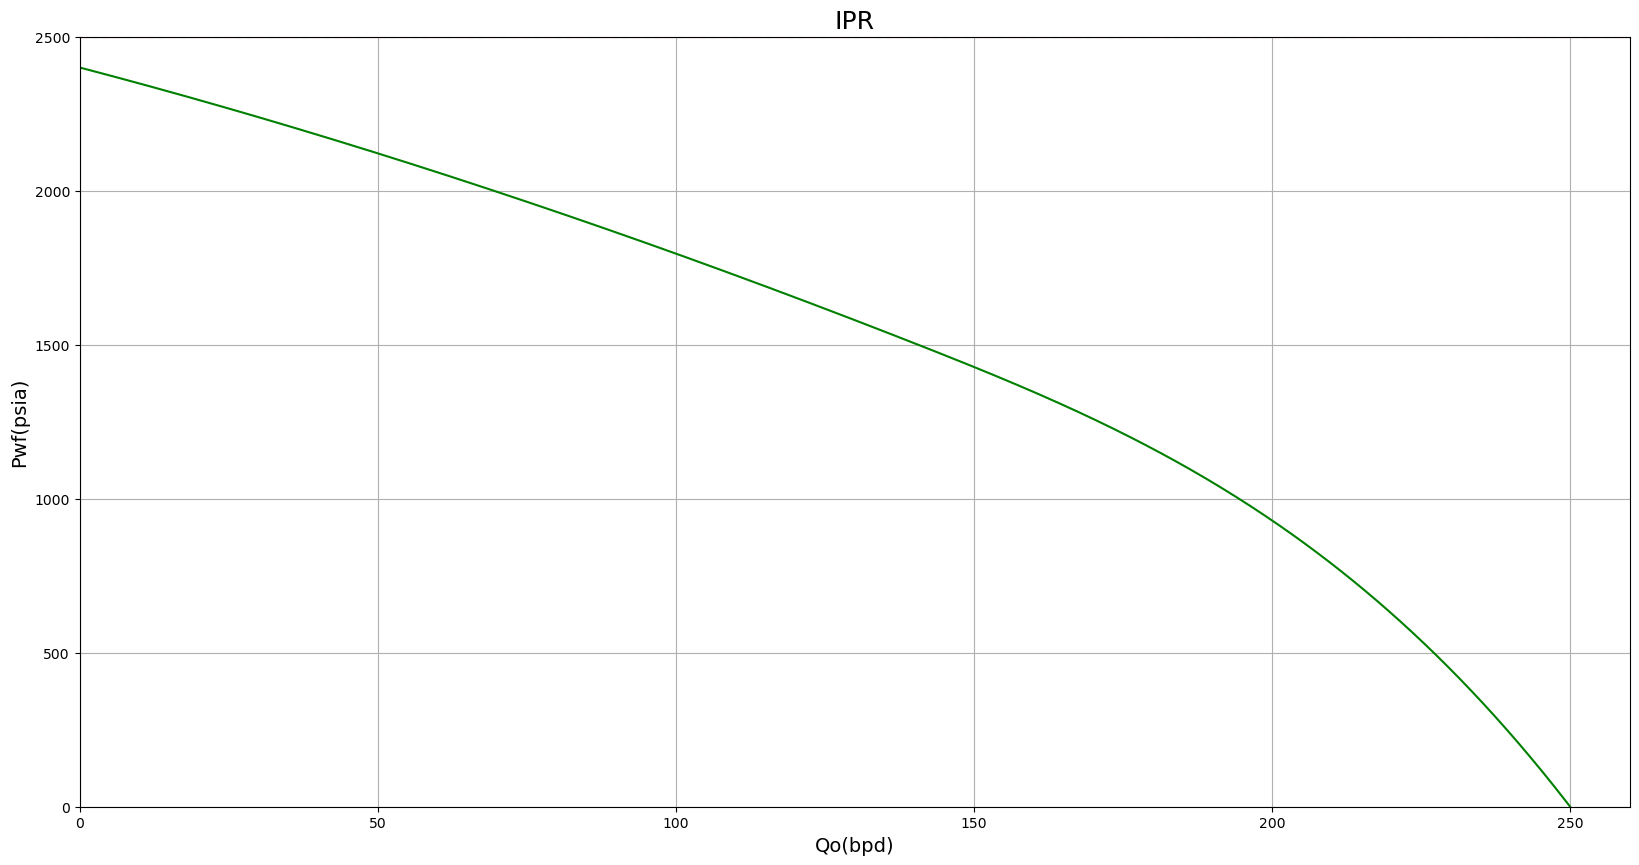

In [26]:
IPR_Curve(q_test, pwf_test, pr, pwf, pb)

## *Exercise 1*

Based on the following data, calculate:

- a) Productivity index
- b) $Q_{o}$ a $Pwf$ = 40 bar
- c) AOF

In [27]:
# Data
pr = 120 #bar
pb = 65 #bar
q_test = 400 #m3/d
pwf_test = 100 #bar

### a) J

In [28]:
IP = j(q_test, pwf_test, pr, pb)
print(f"j -> {IP} m3/dbar")

j -> 20.0 m3/dbar


### b) Qo @Pwf = 40 bar

In [31]:
Q = qo(q_test, pwf_test, pr, 40, pb)
print(f"Qo -> {Q:.3f} m3/d")

Qo -> 1514.530 m3/d


### c) AOF

In [32]:
q_max = aof(q_test, pwf_test, pr, pb)
print(f"AOF -> {q_max} m3/d")

AOF -> 2400.0 m3/d


## *Exercise 2*

Based on the following data, calculate:

- a) AOF
- b) $Q_{o}$ a $Pwf$ = 1200 psi
- c) Plot IPR Curve

In [37]:
# Data
pr = 4000 #psi
pb = 3000 #psi
q_test = 600 #bpd
pwf_test = 2000 #bpd
pwf = np.array([4000, 3500, 3000, 2500, 1000, 0])

### a) AOF

In [38]:
aof(q_test, pwf_test, pr, pb)

864.0

### b) Qo @ Pwf = 1200 psi

In [39]:
qo(q_test, pwf_test, pr, 1200, pb)

751.68

## *Exercise 3*

Based on the following data, calculate:

- a) Productivity index
- b) Oil flow rate at bubble point
- c) AOF
- d) $Q_{o}$ a $Pwf$ = 1500 psi
- e) Plot IPR curve

In [210]:
# Data
pr = 4000 #psi
pb = 3000 #psi
q_test = 600 #bpd
pwf_test = 2000 #bpd
pwf = np.array([4000, 3500, 3000, 2500, 1000, 0])
ef=1